In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Load KOI dataset
df = pd.read_csv('../data/koi_cumulative.csv', comment='#')
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:\n{df['koi_disposition'].value_counts()}")

Dataset shape: (9564, 49)

Class distribution:
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64


## Program 2: Logistic Regression — Exoplanet Candidate Classification

**Scientific Background:**  
NASA's Kepler telescope flagged ~9,500 signals as potential planet transits (KOIs).
Each signal must be vetted as either a genuine planet or a false positive caused by
eclipsing binary stars, background stars, or instrumental noise.

This is a **binary classification problem**:
- `1` → CONFIRMED (real exoplanet)
- `0` → FALSE POSITIVE (not a planet)

We drop CANDIDATEs since they are still under investigation and have no ground truth label.

**Features (X):** Orbital and stellar parameters from Kepler photometry  
**Target (y):** `koi_disposition` → CONFIRMED (1) or FALSE POSITIVE (0)

In [2]:
# Keep only CONFIRMED and FALSE POSITIVE, drop CANDIDATE
data = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])].copy()
print(f"Rows after filtering: {len(data)}")

# Binary encode target
data['label'] = (data['koi_disposition'] == 'CONFIRMED').astype(int)
print(f"\nLabel distribution:\n{data['label'].value_counts()}")
print(f"  1 = CONFIRMED (real planet)")
print(f"  0 = FALSE POSITIVE")

# Select features
features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth',
            'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad']

data = data[features + ['label']].dropna()
print(f"\nUsable rows after dropping NaN: {len(data)}")

X = data[features].values
y = data['label'].values

Rows after filtering: 7585

Label distribution:
label
0    4839
1    2746
Name: count, dtype: int64
  1 = CONFIRMED (real planet)
  0 = FALSE POSITIVE

Usable rows after dropping NaN: 7326


In [3]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("=" * 50)
print("      LOGISTIC REGRESSION RESULTS")
print("=" * 50)
print(f"  Accuracy : {acc:.4f} ({acc*100:.2f}%)")
print(f"  ROC-AUC  : {auc:.4f}")
print("=" * 50)
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred,
      target_names=['FALSE POSITIVE', 'CONFIRMED']))

      LOGISTIC REGRESSION RESULTS
  Accuracy : 0.7401 (74.01%)
  ROC-AUC  : 0.8202

Detailed Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.88      0.68      0.77       917
     CONFIRMED       0.61      0.84      0.71       549

      accuracy                           0.74      1466
     macro avg       0.74      0.76      0.74      1466
  weighted avg       0.78      0.74      0.74      1466



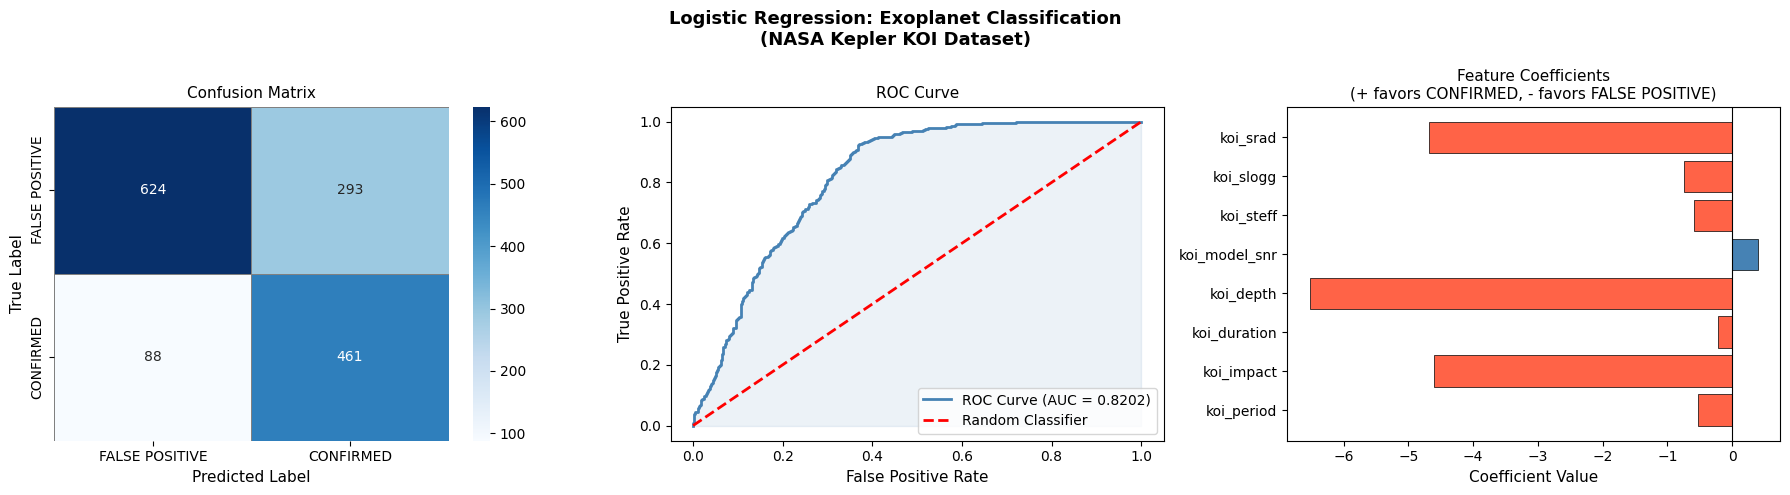

Plot saved!


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Logistic Regression: Exoplanet Classification\n(NASA Kepler KOI Dataset)',
             fontsize=13, fontweight='bold')

# Plot 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['FALSE POSITIVE', 'CONFIRMED'],
            yticklabels=['FALSE POSITIVE', 'CONFIRMED'],
            linewidths=0.5, linecolor='gray')
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_title('Confusion Matrix', fontsize=11)

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, color='steelblue', lw=2, label=f'ROC Curve (AUC = {auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.1, color='steelblue')
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=11)
axes[1].legend(loc='lower right')

# Plot 3: Feature Coefficients
coefs = model.coef_[0]
colors = ['steelblue' if c > 0 else 'tomato' for c in coefs]
axes[2].barh(features, coefs, color=colors, edgecolor='black', linewidth=0.5)
axes[2].axvline(0, color='black', linewidth=0.8)
axes[2].set_xlabel('Coefficient Value', fontsize=11)
axes[2].set_title('Feature Coefficients\n(+ favors CONFIRMED, - favors FALSE POSITIVE)', fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/plots/02_logistic_regression.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plot saved!")

In [5]:
print("Scientific Interpretation")
print("=" * 55)
print(f"""
Logistic Regression classifies Kepler signals as genuine
exoplanets (CONFIRMED) or instrumental artifacts (FALSE POSITIVE).

Dataset: {len(data)} KOI signals (after removing CANDIDATES)
  • CONFIRMED     : {sum(y==1)} signals
  • FALSE POSITIVE: {sum(y==0)} signals

Results:
  • Accuracy : {acc*100:.2f}% — overall correct classifications
  • ROC-AUC  : {auc:.4f} — ability to rank planets above false positives
               (1.0 = perfect, 0.5 = random guessing)

Top discriminating features:
  • koi_model_snr  : Signal-to-noise ratio of the transit
  • koi_depth      : How much starlight is blocked during transit
  • koi_duration   : Duration of the transit event

This model serves as our BASELINE classifier. More powerful
models (Decision Tree, SVM, Gradient Boosting) will be
compared against this in Program 10.
""")

Scientific Interpretation

Logistic Regression classifies Kepler signals as genuine
exoplanets (CONFIRMED) or instrumental artifacts (FALSE POSITIVE).

Dataset: 7326 KOI signals (after removing CANDIDATES)
  • CONFIRMED     : 2744 signals
  • FALSE POSITIVE: 4582 signals

Results:
  • Accuracy : 74.01% — overall correct classifications
  • ROC-AUC  : 0.8202 — ability to rank planets above false positives
               (1.0 = perfect, 0.5 = random guessing)

Top discriminating features:
  • koi_model_snr  : Signal-to-noise ratio of the transit
  • koi_depth      : How much starlight is blocked during transit
  • koi_duration   : Duration of the transit event

This model serves as our BASELINE classifier. More powerful
models (Decision Tree, SVM, Gradient Boosting) will be
compared against this in Program 10.

